In [9]:
DF_PATH = r"../data/raw/explored_df.pkl"
PROCESSED_PATH = r"../data/processed"

In [46]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import joblib


## skelarn -- models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

## sklearn -- metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, RocCurveDisplay, roc_auc_score

## sklearn -- tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score


### Load Processed Data

In [11]:
# load data with pickle
def load_data(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

X_train = load_data(os.path.join(PROCESSED_PATH, 'X_train.pkl'))
y_train = load_data(os.path.join(PROCESSED_PATH, 'y_train.pkl'))
X_val = load_data(os.path.join(PROCESSED_PATH, 'X_val.pkl'))
y_val = load_data(os.path.join(PROCESSED_PATH, 'y_val.pkl'))
X_test  = load_data(os.path.join(PROCESSED_PATH, 'X_test.pkl'))
y_test  = load_data(os.path.join(PROCESSED_PATH, 'y_test.pkl'))
print('Train set:', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set unprocessed :', X_test .shape, y_test .shape)

Train set: (5436, 23) (5436,)
Validation set (1055, 23) (1055,)
Test set unprocessed : (1318, 18) (1318,)


### Model Building without optimization
- Try several classification models and find the outperforming one for later tuning

In [12]:
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Kernel SVM', SVC()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('XGBoost', XGBClassifier()))

In [13]:
acc_results =[]
auc_results =[]
pre_results =[]
f1_results =[]
names = []

result_col = ["Algorithm", "ROC AUC", "Accuracy", "Precision", "f1 Score"]
model_results = pd.DataFrame(columns = result_col)

i=0
# K- fold cross validation

for name, model in models:
    names.append(name)
    
    cv_acc_results = cross_val_score(model, X_train, y_train, 
                     scoring="accuracy")
    cv_auc_results = cross_val_score(model, X_train, y_train,
                     scoring="roc_auc")
    cv_pre_results = cross_val_score(model, X_train, y_train,
                     scoring="precision")
    cv_f1_results = cross_val_score(model, X_train, y_train,
                     scoring="f1")
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    pre_results.append(cv_pre_results)
    f1_results.append(cv_f1_results)
    
    model_results.loc[i] = [name, 
                           round(cv_acc_results.mean()*100,2),
                           round(cv_auc_results.mean()*100,2),
                           round(cv_pre_results.mean()*100,2),
                           round(cv_f1_results.mean()*100,2)]
    i+=1

model_results.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,f1 Score
3,Random Forest,89.48,96.07,90.07,90.67
4,XGBoost,88.39,95.83,89.46,89.77
1,Kernel SVM,83.33,92.03,86.83,84.62
0,Logistic Regression,83.22,91.48,87.07,84.44
2,KNN,82.17,90.30,89.31,82.79


### Finding Good Hyper Parameters on above models indiviually
- Random Forest

In [14]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [15]:
rf_pred_train = rf.predict(X_train)
rf_pred_val = rf.predict(X_val)
rf_acc_train = accuracy_score(rf_pred_train, y_train)
rf_acc_val = accuracy_score(rf_pred_val, y_val)
print(f'Training accuracy {rf_acc_train: .3f}') 
print(f'Validation accuracy {rf_acc_val: .3f}')

Training accuracy  1.000
Validation accuracy  0.864


#### Tuning Hyperparameters

In [19]:
tuned_parameters = [{'n_estimators': [25, 50, 75, 100],
                     'max_features': [15, 20, 25],
                     'max_leaf_nodes': [8, 16, 24]}] # hyperparameters to tune 'max_depth': [3, 5, 7, 10]

rf_grid = GridSearchCV(RandomForestClassifier(), tuned_parameters, 
                   verbose=1, n_jobs=-1) # grid search model
rf_grid.fit(X_train, y_train) 

print("\nBest parameters found:")
print(rf_grid.best_params_) # best hyperparameter values

print("\nGrid scores:")
means = rf_grid.cv_results_['mean_test_score'] # mean accuracy with folds
stds = rf_grid.cv_results_['std_test_score'] # standard deviation of accuracies
# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(means, stds, rf_grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params)) 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters found:
{'max_features': 15, 'max_leaf_nodes': 24, 'n_estimators': 75}

Grid scores:
0.834 (+/-0.036) for {'max_features': 15, 'max_leaf_nodes': 8, 'n_estimators': 25}
0.835 (+/-0.035) for {'max_features': 15, 'max_leaf_nodes': 8, 'n_estimators': 50}
0.835 (+/-0.038) for {'max_features': 15, 'max_leaf_nodes': 8, 'n_estimators': 75}
0.837 (+/-0.030) for {'max_features': 15, 'max_leaf_nodes': 8, 'n_estimators': 100}
0.854 (+/-0.038) for {'max_features': 15, 'max_leaf_nodes': 16, 'n_estimators': 25}
0.853 (+/-0.038) for {'max_features': 15, 'max_leaf_nodes': 16, 'n_estimators': 50}
0.856 (+/-0.037) for {'max_features': 15, 'max_leaf_nodes': 16, 'n_estimators': 75}
0.857 (+/-0.035) for {'max_features': 15, 'max_leaf_nodes': 16, 'n_estimators': 100}
0.859 (+/-0.037) for {'max_features': 15, 'max_leaf_nodes': 24, 'n_estimators': 25}
0.858 (+/-0.044) for {'max_features': 15, 'max_leaf_nodes': 24, 'n_estimators': 50}

RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=75)
Results on test data
Val accuracy =  0.8588
Val precision =  0.9118
Val recall =  0.8889
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       299
           1       0.91      0.89      0.90       756

    accuracy                           0.86      1055
   macro avg       0.82      0.84      0.83      1055
weighted avg       0.86      0.86      0.86      1055

Confusion matrix (Rows actual, Columns predicted):
     0    1
0  234   65
1   84  672

ROC curve


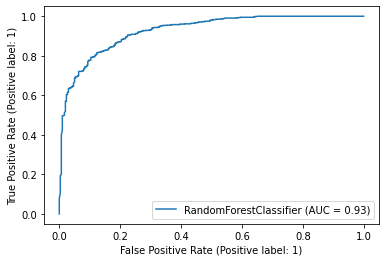

In [21]:
# Specify non-default hyper-parameter values
from sklearn.metrics import precision_score, recall_score, RocCurveDisplay


max_features = 15
max_leaf_nodes = 24 
n_estimators = 75

# Train and test model
good_model_rf = RandomForestClassifier(max_leaf_nodes = max_leaf_nodes,
                                    max_features = max_features, 
                                    n_estimators=n_estimators) 

print(good_model_rf) # display model parameters
good_model_rf.fit(X_train, y_train) # train model
pred_rf = good_model_rf.predict(X_val) 

print("Results on val data")
acc_rf = accuracy_score(y_val, pred_rf) 
prec_rf = precision_score(y_val, pred_rf) 
reca_rf = recall_score(y_val, pred_rf) 

print(f'Val accuracy = {acc_rf: .4f}') 
print(f'Val precision = {prec_rf: .4f}')
print(f'Val recall = {reca_rf: .4f}') 
print("Classification report:")
print(classification_report(y_val, pred_rf))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_val, pred_rf)))

print('\nROC curve')
RocCurveDisplay.from_estimator(good_model_rf, X_val, y_val)
plt.show()

- XGBoost	

In [23]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [25]:
xgb_pred_train = xgb.predict(X_train)
xgb_pred_val = xgb.predict(X_val)
xgb_acc_train = accuracy_score(xgb_pred_train, y_train)
xgb_acc_val = accuracy_score(xgb_pred_val, y_val)
print(f'Training accuracy {xgb_acc_train: .3f}') 
print(f'Validation accuracy {xgb_acc_val: .3f}')

Training accuracy  0.992
Validation accuracy  0.848


#### Tuning Hyperparameter for XGBoost

- `Reference`: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
- https://www.kaggle.com/code/michalbrezk/xgboost-classifier-and-hyperparameter-tuning-85

- eta
- gamma
- max_depth
- min_child_weight
- max_delta_step
- subsample 
- colsample_bytree, colsample_bylevel, colsample_bynode 
- lambda
- alpha
- tree_method
- scale_pos_weight
- max_leaves

In [27]:
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05,0.1],
    'booster': ['gbtree'],
    'gamma': [0.5, 1],
    'reg_alpha': [0.5, 1],
    'reg_lambda': [1, 5]
}

xgb_grid = GridSearchCV(XGBClassifier(n_jobs=-1), params, 
                   verbose=1, scoring='roc_auc') # grid search model
xgb_grid.fit(X_train, y_train) 

print("\nBest parameters found:")
print(xgb_grid.best_params_) # best hyperparameter values

print("\nGrid scores:")
means = xgb_grid.cv_results_['mean_test_score'] # mean accuracy with folds
stds = xgb_grid.cv_results_['std_test_score'] # standard deviation of accuracies
# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(means, stds, xgb_grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params)) 

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters found:
{'booster': 'gbtree', 'gamma': 0.5, 'learning_rate': 0.1, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1}

Grid scores:
0.948 (+/-0.031) for {'booster': 'gbtree', 'gamma': 0.5, 'learning_rate': 0.05, 'n_estimators': 50, 'reg_alpha': 0.5, 'reg_lambda': 1}
0.947 (+/-0.031) for {'booster': 'gbtree', 'gamma': 0.5, 'learning_rate': 0.05, 'n_estimators': 50, 'reg_alpha': 0.5, 'reg_lambda': 5}
0.948 (+/-0.031) for {'booster': 'gbtree', 'gamma': 0.5, 'learning_rate': 0.05, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 1}
0.946 (+/-0.031) for {'booster': 'gbtree', 'gamma': 0.5, 'learning_rate': 0.05, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 5}
0.954 (+/-0.034) for {'booster': 'gbtree', 'gamma': 0.5, 'learning_rate': 0.05, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 1}
0.952 (+/-0.032) for {'booster': 'gbtree', 'gamma': 0.5, 'learning_rate': 0.05, 'n_estimators': 100, 'reg_alpha': 

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
Results on val data
Val accuracy =  0.8521
Val precision =  0.8979
Val recall =  0.8955
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       299
           1       0.90     

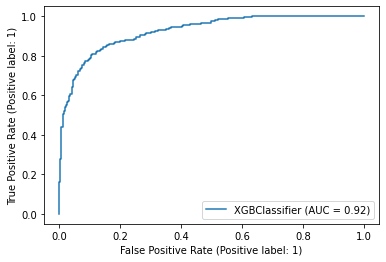

In [28]:
# Specify non-default hyper-parameter values

booster = 'gbtree'
gamma = 0.5
learning_rate = 0.1
n_estimators = 200
reg_alpha = 0.5
reg_lambda = 1

# Train and test model
good_model_xgb = XGBClassifier(booster = 'gbtree',
                              gamma = 0.5,
                              learning_rate = 0.1,
                              n_estimators = 200,
                              reg_alpha = 0.5,
                              reg_lambda = 1, random_state=42) 

print(good_model_xgb) # display model parameters
good_model_xgb.fit(X_train, y_train) # train model
pred_xgb = good_model_xgb.predict(X_val) 

print("Results on val data")
acc_xgb = accuracy_score(y_val, pred_xgb) 
prec_xgb = precision_score(y_val, pred_xgb) 
reca_xgb = recall_score(y_val, pred_xgb) 

print(f'Val accuracy = {acc_xgb: .4f}') 
print(f'Val precision = {prec_xgb: .4f}')
print(f'Val recall = {reca_xgb: .4f}') 
print("Classification report:")
print(classification_report(y_val, pred_xgb))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_val, pred_xgb)))

print('\nROC curve')
RocCurveDisplay.from_estimator(good_model_xgb, X_val, y_val)
plt.show()

### Random Forest and XGBClassifier have very similar results

- Kernel SVM

In [29]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [30]:
svc_pred_train = svc.predict(X_train)
svc_pred_val = svc.predict(X_val)
svc_acc_train = accuracy_score(svc_pred_train, y_train)
svc_acc_val = accuracy_score(svc_pred_val, y_val)
print(f'Training accuracy {svc_acc_train: .3f}') 
print(f'Validation accuracy {svc_acc_val: .3f}')

Training accuracy  0.843
Validation accuracy  0.834


#### Tuning The Hyperparameters of SVC

In [31]:
tuned_parameters = [{'kernel':['linear', 'rbf', 'sigmoid'], 'gamma':[1, 'auto'], 'C':[1, 2, 3]}] # hyperparameters to tune

svc_grid= GridSearchCV(SVC(), tuned_parameters, 
                   verbose=1, n_jobs=-1) # grid search model
svc_grid.fit(X_train,y_train) 

print("\nBest parameters found:")
print(svc_grid.best_params_) # best hyperparameter values

print("\nGrid scores:")
meansvm = svc_grid.cv_results_['mean_test_score'] # mean accuracy with folds
stdsvm = svc_grid.cv_results_['std_test_score'] # standard deviation of accuracies
# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(meansvm, stdsvm, svc_grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params)) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best parameters found:
{'C': 3, 'gamma': 1, 'kernel': 'rbf'}

Grid scores:
0.829 (+/-0.032) for {'C': 1, 'gamma': 1, 'kernel': 'linear'}
0.859 (+/-0.038) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.547 (+/-0.011) for {'C': 1, 'gamma': 1, 'kernel': 'sigmoid'}
0.829 (+/-0.032) for {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
0.826 (+/-0.024) for {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.797 (+/-0.022) for {'C': 1, 'gamma': 'auto', 'kernel': 'sigmoid'}
0.830 (+/-0.028) for {'C': 2, 'gamma': 1, 'kernel': 'linear'}
0.864 (+/-0.045) for {'C': 2, 'gamma': 1, 'kernel': 'rbf'}
0.546 (+/-0.016) for {'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}
0.830 (+/-0.028) for {'C': 2, 'gamma': 'auto', 'kernel': 'linear'}
0.831 (+/-0.025) for {'C': 2, 'gamma': 'auto', 'kernel': 'rbf'}
0.777 (+/-0.031) for {'C': 2, 'gamma': 'auto', 'kernel': 'sigmoid'}
0.830 (+/-0.031) for {'C': 3, 'gamma': 1, 'kernel': 'linear'}
0.870 (+/-0.054) for {'C': 3, 'gamm

SVC(C=3, gamma=1, random_state=42)
Results on val data
Val accuracy =  0.8161
Val precision =  0.8849
Val recall =  0.8545
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69       299
           1       0.88      0.85      0.87       756

    accuracy                           0.82      1055
   macro avg       0.77      0.79      0.78      1055
weighted avg       0.82      0.82      0.82      1055

Confusion matrix (Rows actual, Columns predicted):
     0    1
0  215   84
1  110  646

ROC curve


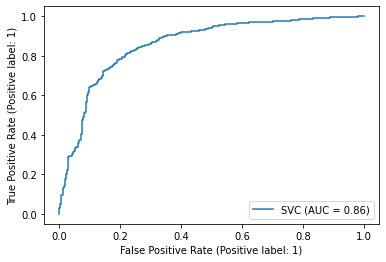

In [33]:
# Specify non-default hyper-parameter values

C = 3
gamma = 1
kernel = 'rbf'

# Train and test model
good_model_svc = SVC(C = 3, gamma = 1, kernel = 'rbf', random_state=42) 

print(good_model_svc) # display model parameters
good_model_svc.fit(X_train, y_train) # train model
pred_svc = good_model_svc.predict(X_val) 

print("Results on val data")
acc_svc = accuracy_score(y_val, pred_svc) 
prec_svc = precision_score(y_val, pred_svc) 
reca_svc = recall_score(y_val, pred_svc) 

print(f'Val accuracy = {acc_svc: .4f}') 
print(f'Val precision = {prec_svc: .4f}')
print(f'Val recall = {reca_svc: .4f}') 
print("Classification report:")
print(classification_report(y_val, pred_svc))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_val, pred_svc)))

print('\nROC curve')
RocCurveDisplay.from_estimator(good_model_svc, X_val, y_val)
plt.show()

- Logistic Regression

In [34]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [35]:
lr_pred_train = lr.predict(X_train)
lr_pred_val = lr.predict(X_val)
lr_acc_train = accuracy_score(lr_pred_train, y_train)
lr_acc_val = accuracy_score(lr_pred_val, y_val)
print(f'Training accuracy {lr_acc_train: .3f}') 
print(f'Validation accuracy {lr_acc_val: .3f}')

Training accuracy  0.833
Validation accuracy  0.827


#### Tuning the Hyperparameters for LogisticRegression

In [36]:
tuned_parameters = [{'C': [10.0, 100.0, 1000.0],
                     'max_iter': [500, 1000, 1500]}] # hyperparameters to tune

lr_grid= GridSearchCV(LogisticRegression(), tuned_parameters, 
                   verbose=1, n_jobs=-1) # grid search model
lr_grid.fit(X_train,y_train) 

print("\nBest parameters found:")
print(lr_grid.best_params_) # best hyperparameter values

print("\nGrid scores:")
meanlr = lr_grid.cv_results_['mean_test_score'] # mean accuracy with folds
stdlr = lr_grid.cv_results_['std_test_score'] # standard deviation of accuracies
# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(meanlr, stdlr, lr_grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params)) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best parameters found:
{'C': 1000.0, 'max_iter': 500}

Grid scores:
0.833 (+/-0.023) for {'C': 10.0, 'max_iter': 500}
0.833 (+/-0.023) for {'C': 10.0, 'max_iter': 1000}
0.833 (+/-0.023) for {'C': 10.0, 'max_iter': 1500}
0.833 (+/-0.021) for {'C': 100.0, 'max_iter': 500}
0.833 (+/-0.021) for {'C': 100.0, 'max_iter': 1000}
0.833 (+/-0.021) for {'C': 100.0, 'max_iter': 1500}
0.833 (+/-0.021) for {'C': 1000.0, 'max_iter': 500}
0.833 (+/-0.021) for {'C': 1000.0, 'max_iter': 1000}
0.833 (+/-0.021) for {'C': 1000.0, 'max_iter': 1500}


LogisticRegression(C=1000.0, max_iter=500)
Results on val data
Val accuracy =  0.8237
Val precision =  0.9318
Val recall =  0.8135
Classification report:
              precision    recall  f1-score   support

           0       0.64      0.85      0.73       299
           1       0.93      0.81      0.87       756

    accuracy                           0.82      1055
   macro avg       0.79      0.83      0.80      1055
weighted avg       0.85      0.82      0.83      1055

Confusion matrix (Rows actual, Columns predicted):
     0    1
0  254   45
1  141  615

ROC curve


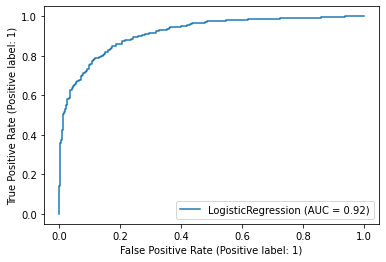

In [37]:
# Specify non-default hyper-parameter values

C = 1000.0
max_iter = 500

# Train and test model
good_model_lr = LogisticRegression(C = 1000.0, max_iter = 500) 

print(good_model_lr) # display model parameters
good_model_lr.fit(X_train, y_train) # train model
pred_lr = good_model_lr.predict(X_val) 

print("Results on val data")
acc_lr = accuracy_score(y_val, pred_lr) 
prec_lr = precision_score(y_val, pred_lr) 
reca_lr = recall_score(y_val, pred_lr) 

print(f'Val accuracy = {acc_lr: .4f}') 
print(f'Val precision = {prec_lr: .4f}')
print(f'Val recall = {reca_lr: .4f}') 
print("Classification report:")
print(classification_report(y_val, pred_lr))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_val, pred_lr)))

print('\nROC curve')
RocCurveDisplay.from_estimator(good_model_lr, X_val, y_val)
plt.show()

In [39]:
good_model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 15,
 'max_leaf_nodes': 24,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 75,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Preview best model scores

In [41]:
models_opt = []

models_opt.append(('Logistic Regression', LogisticRegression(solver='lbfgs', C=1000, max_iter=1000, random_state=42)))
models_opt.append(('Kernel SVM', SVC(C=3, gamma=1, kernel='rbf', random_state=42)))
models_opt.append(('XGBoost', XGBClassifier(booster = 'gbtree', gamma = 0.5, learning_rate = 0.1, n_estimators = 200,
                              reg_alpha = 0.5, reg_lambda = 1, random_state=42)))
models_opt.append(('Random Forest', RandomForestClassifier(max_leaf_nodes=15, max_features=24, n_estimators=75, criterion='gini', random_state=42)))

In [45]:
acc_results_opt =[]
auc_results_opt =[]
pre_results_opt =[]
f1_results_opt =[]
names_opt = []

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", 'Precision', 'F1 Scores']
model_results_opt = pd.DataFrame(columns = result_col_opt)

i=0
# K- fold cross validation

for name, model in models_opt:
    names_opt.append(name)
    
    cv_acc_results_opt = cross_val_score(model, X_train, y_train, scoring="accuracy")
    cv_auc_results_opt = cross_val_score(model, X_train, y_train, scoring="roc_auc")
    cv_pre_results_opt = cross_val_score(model, X_train, y_train, scoring="precision")
    cv_f1_results_opt = cross_val_score(model, X_train, y_train, scoring="f1")

    acc_results_opt.append(cv_acc_results_opt)
    auc_results_opt.append(cv_auc_results_opt)
    pre_results_opt.append(cv_pre_results_opt)
    f1_results_opt.append(cv_f1_results_opt)
    
    model_results_opt.loc[i] = [name, 
                           round(cv_auc_results_opt.mean()*100,2),
                           round(cv_acc_results_opt.mean()*100,2),
                           round(cv_pre_results_opt.mean()*100,2),
                           round(cv_f1_results_opt.mean()*100,2)]
    i+=1

model_results_opt.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,F1 Scores
2,XGBoost,95.94,88.65,89.61,89.99
1,Kernel SVM,93.90,86.96,91.32,87.91
3,Random Forest,93.22,85.36,85.97,87.01
0,Logistic Regression,91.63,83.33,87.28,84.53


In [49]:
# precision_score  recall_score

acc_results_opt_val =[]
auc_results_opt_val =[]
pre_results_opt_val =[]
f1_results_opt_val =[]
rec_results_opt_val =[]
names_opt_val = []
good_models_names = [('RandomForest', pred_rf), ('LogisticRegression', pred_lr), ('Kernel SVC', pred_svc), ('XGBoost', pred_xgb)]

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", 'Precision', 'Recall', 'F1 Scores']
model_results_opt_val = pd.DataFrame(columns = result_col_opt)

i=0
# K- fold cross validation

for name, y_pred in good_models_names:
    names_opt_val.append(name)
    
    cv_acc_results_opt = accuracy_score(y_val, y_pred)
    cv_auc_results_opt = roc_auc_score(y_val, y_pred)
    cv_pre_results_opt = precision_score(y_val, y_pred)
    cv_f1_results_opt = f1_score(y_val, y_pred)
    cv_rec_results_opt = recall_score(y_val, y_pred)

    acc_results_opt_val.append(cv_acc_results_opt)
    auc_results_opt_val.append(cv_auc_results_opt)
    pre_results_opt_val.append(cv_pre_results_opt)
    f1_results_opt_val.append(cv_f1_results_opt)
    rec_results_opt_val.append(cv_rec_results_opt)

    model_results_opt_val.loc[i] = [name, 
                           round(cv_auc_results_opt.mean()*100,2),
                           round(cv_acc_results_opt.mean()*100,2),
                           round(cv_pre_results_opt.mean()*100,2),
                           round(cv_rec_results_opt.mean()*100,2),
                           round(cv_f1_results_opt.mean()*100,2)]
    i+=1

model_results_opt_val.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,Recall,F1 Scores
0,RandomForest,83.57,85.88,91.18,88.89,90.02
1,LogisticRegression,83.15,82.37,93.18,81.35,86.86
3,XGBoost,81.90,85.21,89.79,89.55,89.67
2,Kernel SVC,78.68,81.61,88.49,85.45,86.94


#### Best Model
- `RandomForest` overperforms all models on `validation` set while `XGBoost` overperforms on `training` set

### TODO
- Combine training set and validation set together
- Train RandomForest and XGBoost on the combined dataset
- Evaluate on test data
- Save best model for deployment

### Saving RandomForest and XGBoost models for later use

In [51]:
# saving RandomForest
joblib.dump(good_model_rf, '../models/min_forest_tuned.pkl')

# saving XGBoost
joblib.dump(good_model_xgb,'../models/min_XGBoost_tuned.pkl')

['../models/min_XGBoost_tuned.pkl']